  6.491054 seconds (15.90 M allocations: 1.592 GiB, 5.82% gc time, 85.48% compilation time)
  0.021356 seconds (21.97 k allocations: 1.320 MiB, 99.59% compilation time)
Learned parameters:[1.730299394380092, 1.2823309406552328, -1.6866221808779036, 0.41975285362090164, 1.223076079870088, 0.9410698291271117, 0.18890983943646267, 1.746298235434072]


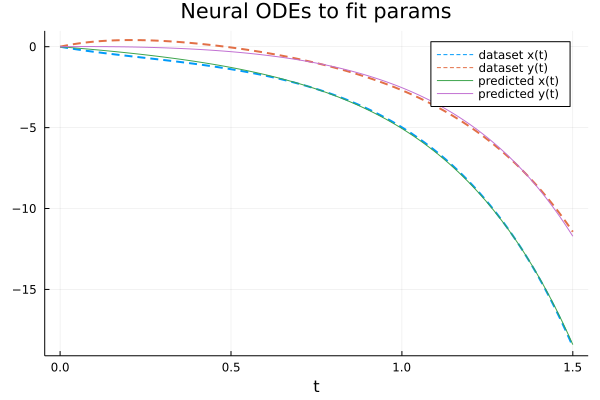

In [34]:
#=
For details, please visit:
https://computationalmindset.com/en/neural-networks/experiments-with-neural-odes-in-julia.html#exp1
Parametric system to train:
x' = a1 x + b1 y + c1 e^(-d1 t)
y' = a2 x + b2 y + c2 e^(-d2 t)
x(0) = 0
y(0) = 0
to generate dataset use the following param values
a1 = 1.11
b1 = 2.43
c1 = -3.66
d1 = 1.37
a2 = 2.89
b2 = -1.97
c2 = 4.58
d2 = 2.86
Analytical solution is:
https://www.wolframalpha.com/input/?i=x%27+%3D+1.11+x+%2B+2.43+y+%2B+-3.66+e%5E%28-1.37+t%29%3B+y%27+%3D+2.89+x+-1.97+y+%2B+4.58+e%5E+%28-2.86+t%29%3B+x%280%29%3D0%3B+y%280%29%3D0%3B
=#

using Flux, DiffEqFlux, DifferentialEquations, Plots

function parametric_ode_system!(du,u,p,t)
  x, y = u
  a1, b1, c1, d1, a2, b2, c2, d2 = p
  du[1] = dx = a1*x + b1*y + c1*exp(-d1*t)
  du[2] = dy = a2*x + b2*y + c2*exp(-d2*t)
end

true_params = [1.11, 2.43, -3.66, 1.37, 2.89, -1.97, 4.58, 2.86]

an_sol_x(t) =
  -1.38778e-17 * exp(-8.99002 * t) -
  2.77556e-17 * exp(-7.50002 * t) +
  3.28757 * exp(-3.49501 * t) -
  3.18949 * exp(-2.86 * t) +
  0.258028 * exp(-1.37 * t) -
  0.356108 * exp(2.63501 * t) +
  4.44089e-16 * exp(3.27002 * t) +
  1.11022e-16 * exp(4.76002 * t)
an_sol_y(t) =
  -6.23016 * exp(-3.49501 * t) +
  5.21081 * exp(-2.86 * t) +
  1.24284 * exp(-1.37 * t) -
  0.223485 * exp(2.63501 * t) +
  2.77556e-17 * exp(4.76002 * t)

tbegin=0.0
tend=1.5
tstep=0.01
trange = tbegin:tstep:tend
u0 = [0.0,0.0]
tspan = (tbegin,tend)
p = ones(8)

prob = ODEProblem(parametric_ode_system!, u0, tspan, p)

function net()
    solve(prob, Tsit5(), p=p, saveat=trange)
end

dataset_outs = [an_sol_x.(trange), an_sol_y.(trange)]
function loss_func()
  pred = net()
  sum(abs2, dataset_outs[1] .- pred[1,:]) +
  sum(abs2, dataset_outs[2] .- pred[2,:])
end

epochs = 1000
learning_rate = 0.05
data = Iterators.repeated((), epochs)
opt = ADAM(learning_rate)

callback_func = function ()
  loss_value = loss_func()
  #println("Loss: ", loss_value)
end
fparams = Flux.params(p)
@time Flux.train!(loss_func, fparams, data, opt, cb=callback_func)

predict_prob = ODEProblem(parametric_ode_system!, u0, tspan, p)
@time predict_sol = solve(prob, Tsit5(), saveat=trange)
x_predict_sol = [u[1] for u in predict_sol.u]
y_predict_sol = [u[2] for u in predict_sol.u]

println("Learned parameters:", p)

plot(trange, dataset_outs[1],
    linewidth=2, ls=:dash,
    title="Neural ODEs to fit params",
    xaxis="t",
    label="dataset x(t)",
    legend=true)
plot!(trange, dataset_outs[2],
    linewidth=2, ls=:dash,
    label="dataset y(t)")
plot!(predict_sol.t, x_predict_sol,
    linewidth=1,
    label="predicted x(t)")
plot!(predict_sol.t, y_predict_sol,
    linewidth=1,
    label="predicted y(t)")